In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [4]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')


In [18]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [19]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [20]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [21]:
y_value_counts = project_data['project_is_approved'].value_counts()


In [22]:
data = [y_value_counts[1], y_value_counts[0]]
labels=['Approved','Not Approved']
colors=['#97C1A9','#FF968A']
layout =go.Layout(title='Project status')
fig=go.Figure(data=[go.Pie(labels=labels,values=data,hole=.5,marker=dict(colors=colors))],layout=layout)
fig.show()

In [23]:
temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)


In [24]:
temp.columns = ['state_code', 'num_proposals']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

#scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            #[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
scl=[[0.0,'#A2E2F8'],[0.25,'#75BDE0'],[0.75,'#4A8DB7'],[1.0,'#3B7097']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
      ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
#offline.iplot(fig, filename='us-map-heat-map')
fig.show()

In [25]:
temp1 = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].agg(lambda x: x.eq(1).sum())).reset_index()

temp1.head()

school_state  project_is_approved
0           AK                  290
1           AL                 1506
2           AR                  872
3           AZ                 1800
4           CA                13205

In [26]:
temp1['total'] = pd.DataFrame(project_data.groupby('school_state')['project_is_approved'].agg(total='count')).reset_index()['total']
temp1['Avg'] = pd.DataFrame(project_data.groupby('school_state')['project_is_approved'].agg(Avg='mean')).reset_index()['Avg']
temp1.sort_values(by=['total'],inplace=True, ascending=False)
temp1.head()

school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038

In [27]:
trace1=go.Bar(x=temp1['school_state'],y=temp1['total'],name='Total',marker={'color':'#345DA7'})
trace2=go.Bar(x=temp1['school_state'],y=temp1['project_is_approved'],name='Approved',marker={'color':'#4BB4DE'})
layout=go.Layout(title='State Total vs Approved')
data=[trace1,trace2]
fig=go.Figure(data=data,layout=layout)
fig.show()
            



In [28]:
temp2=pd.DataFrame(project_data.groupby('teacher_prefix')
                    ["project_is_approved"].agg(lambda x: x.eq(1).sum())).reset_index()
temp2['total'] = pd.DataFrame(project_data.groupby('teacher_prefix')
                    ['project_is_approved'].agg(total='count')).reset_index()['total']
temp2.head()
                                        

teacher_prefix  project_is_approved  total
0            Dr.                    9     13
1            Mr.                 8960  10648
2           Mrs.                48997  57269
3            Ms.                32860  38955
4        Teacher                 1877   2360

In [29]:
trace1=go.Bar(x=temp2['teacher_prefix'],y=temp2['total'],name='Total',marker={'color':'#345DA7'})
trace2=go.Bar(x=temp2['teacher_prefix'],y=temp2['project_is_approved'],name='Approved',marker={'color':'#4BB4DE'})
layout=go.Layout(title='Teacher Total vs Approved')
data=[trace1,trace2]
fig=go.Figure(data=data,layout=layout)
fig.show()
           

In [30]:
temp3=pd.DataFrame(project_data.groupby('project_grade_category')
                    ["project_is_approved"].agg(lambda x: x.eq(1).sum())).reset_index()
temp3['total'] = pd.DataFrame(project_data.groupby('project_grade_category')
                    ['project_is_approved'].agg(total='count')).reset_index()['total']

trace1=go.Bar(x=temp3['project_grade_category'],y=temp3['total'],name='Total',marker={'color':'#345DA7'})
trace2=go.Bar(x=temp3['project_grade_category'],y=temp3['project_is_approved'],name='Approved',marker={'color':'#4BB4DE'})
layout=go.Layout(title='Grade Total vs Approved')
data=[trace1,trace2]
fig=go.Figure(data=data,layout=layout)
fig.show()

In [31]:
catogories = list(project_data['project_subject_categories'].values)
sub_cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories  \
0                Literacy & Language   
1  History & Civics, Health & Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

            clean_subcategories  
0             Literacy_Language  
1  History_Civics Health_Sports

In [32]:
temp3=pd.DataFrame(project_data.groupby('clean_subcategories')
                    ["project_is_approved"].agg(lambda x: x.eq(1).sum())).reset_index()
temp3['total'] = pd.DataFrame(project_data.groupby('clean_subcategories')
                    ['project_is_approved'].agg(total='count')).reset_index()['total']

trace1=go.Bar(x=temp3['clean_subcategories'],y=temp3['total'],name='Total',marker={'color':'#345DA7'})
trace2=go.Bar(x=temp3['clean_subcategories'],y=temp3['project_is_approved'],name='Approved',marker={'color':'#4BB4DE'})
layout=go.Layout(title='Sub_categories Total vs Approved')
data=[trace1,trace2]
fig=go.Figure(data=data,layout=layout)
fig.show()

In [33]:
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
indx = np.arange(len(word_dict))
indy=list(word_dict.values())
trace=go.Bar(x=indx,y=indy,marker={'color':'#8ad879'})
data=[trace]
layout= go.Layout(title='Words')
fig=go.Figure(data=data,layout=layout)
fig.show()


In [34]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories  \
0                  Literacy & Language   
1    History & Civics, Health & Sports   
2                      Health & Sports   
3  Literacy & Language, Math & Science   
4                       Math & Science   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

              clean_subcategories  
0               Literacy_Language  
1    History_Civics Health_Sports  
2                   Health_Sports  
3  Literacy_Language Math_Science  
4                    Math_Science

In [35]:
import pandas as pd

In [36]:
df=pd.read_csv('preprocessed_data_web.csv')

In [37]:
df.head()

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   
3           ga            mrs          grades_prek_2   
4           wa            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   
3                                             2                    1   
4                                             2                    1   

    clean_categories                 clean_subcategories  \
0       math_science  appliedsciences health_lifescience   
1       specialneeds                        specialneeds   
2  literacy_language                            literacy   
3    appliedlearning                    earlydevelopment   
4  literacy_language                            literacy   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00  
3  i recently read article giving students choice...  481.04  
4  my students crave challenge eat obstacles brea...   17.74

In [7]:
data_url='https://raw.githubusercontent.com/Pritam-source/data_source/main/preprocessed_data_web.csv'
df = pd.read_csv(data_url)

In [5]:
y_value_counts = project_data['project_is_approved'].value_counts()

In [6]:
data = [y_value_counts[1], y_value_counts[0]]
labels=['Approved','Not Approved']
colors=['#97C1A9','#FF968A']
layout =go.Layout(title='Project status')
fig=go.Figure(data=[go.Pie(labels=labels,values=data,hole=.5,marker=dict(colors=colors))],layout=layout)
fig.show()

In [7]:
import pickle

In [8]:
outfile=open('mydata.pkl','wb')
pickle.dump(fig,outfile)
outfile.close

<function BufferedWriter.close>

In [9]:
infile=open('mydata.pkl','rb')
z=pickle.load(infile)

EOFError: Ran out of input

In [10]:
with open('model_pickle','wb')as f:
    pickle.dump(fig,f)


In [11]:
with open('model_pickle','rb') as f: 
    mp=pickle.load(f)

In [12]:
mp.show()

In [13]:
df.essay.count()

10000

In [14]:
import nltk

In [15]:
word_cloud_material=[]
for i in df.essay:
    word_cloud_material.append(i)

In [18]:
word_cloud_stage1=nltk.word_tokenize(word_cloud_material)

TypeError: expected string or bytes-like object

In [19]:
print(type(word_cloud_material))

<class 'list'>


In [8]:
import re

In [9]:
storage=[]
for i in df.essay:
    wordcld=i.split(' ')
    storage.extend(wordcld)

    


In [10]:
wrdcld=pd.DataFrame(storage,columns=['one'])

In [8]:
wrdcld.to_csv("wordcld.csv",index=False)

In [11]:
gen=wrdcld.one.value_counts()

In [14]:
gen

students      73574
i             31898
school        23196
learning      16557
my            16233
              ...  
energitic         1
prefers           1
wedgits           1
inquisitve        1
obsession         1
Name: one, Length: 22692, dtype: int64

In [12]:
from wordcloud import WordCloud,STOPWORDS

In [13]:
wordcloud=WordCloud(width=1280,height=720,stopwords=STOPWORDS,
                    background_color='white',repeat=False)

In [14]:
main_file_wordcld=wordcloud.generate_from_frequencies(gen)

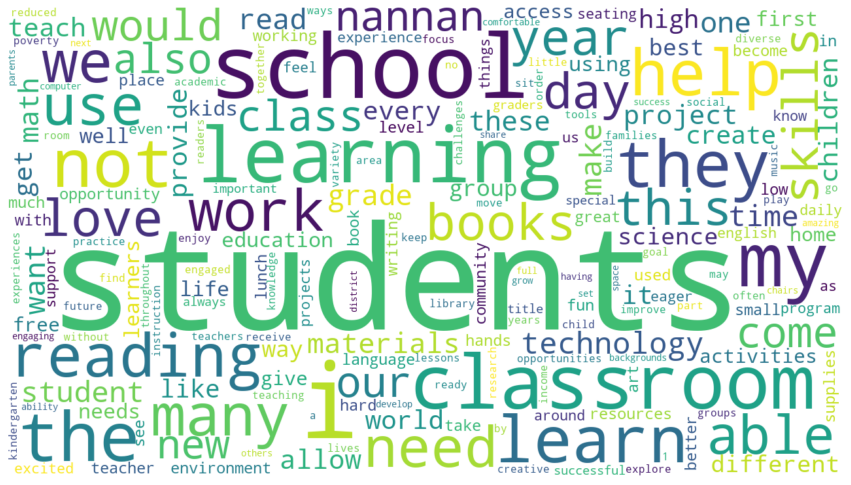

In [15]:
fig=plt.figure(figsize=(15,10))
plt.imshow(main_file_wordcld,interpolation='bilinear')
plt.axis('off')
plt.show()               

In [16]:
wordcloud.to_file("cld1.png")

In [29]:
with open('graph_wrdcld','wb')as f:
    pickle.dump(main_file_wordcld,f)

In [30]:
with open('graph_wrdcld','rb') as f: 
    graph_wrdcld=pickle.load(f)

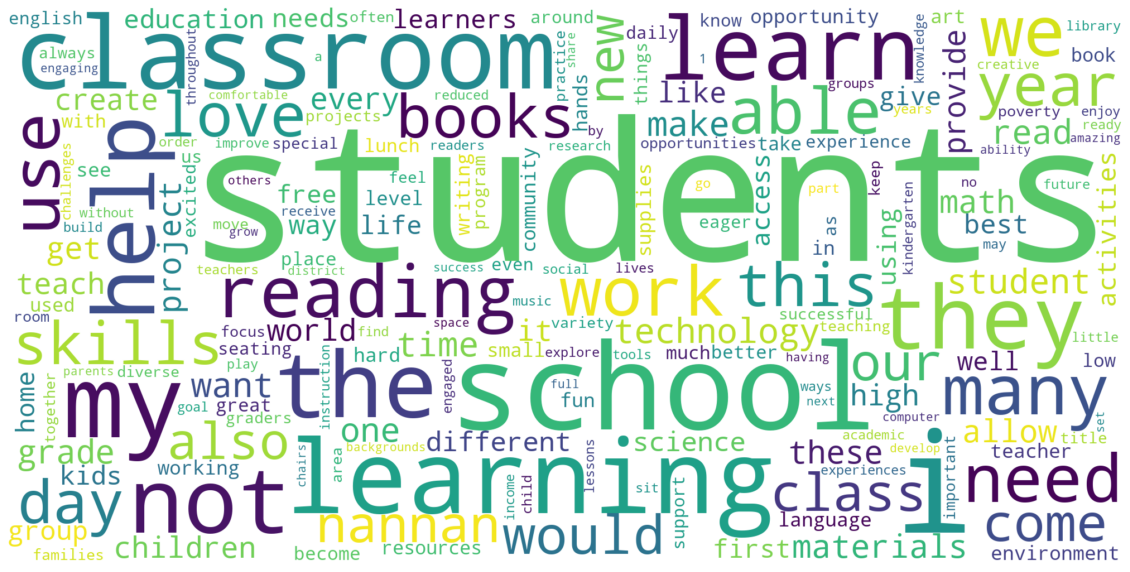

In [31]:
fig=plt.figure(figsize=(20,15))
plt.imshow(graph_wrdcld,interpolation='bilinear')
plt.axis('off')
plt.show() 